# Exact Diagonalization Approach

In [1]:
import numpy as np             # Array operations
import pandas as pd            # Data handling
import matplotlib.pyplot as plt  # Plotting
from scipy.sparse import csr_array  # Compressed sparse row arrays
from scipy.linalg import eigh, expm  # Matrix routines and exponential

In [2]:
#--------------------------------------------------------------------
# Helper Functions: Define basis state generation and bit manipulation
#--------------------------------------------------------------------

def basis_states(N):
    """
    Generate a list of basis states represented by integers using bitwise representation.
    For N sites, each state is represented by an integer in the range [0, 4**N).
    """
    return [i for i in range(4**N)]

def position(site, spin):
    """
    Determine the bit position for a given site and spin.
    Spin: 1 for up, 0 for down.
    """
    return 2 * site + (1 - spin)

def extract_bit(number, pos):
    """
    Extract the bit at position 'pos' from 'number'.
    Returns 1 if the bit is set, 0 otherwise.
    """
    return (number >> pos) & 1

def sum_bits_upto(number, pos):
    """
    Count the number of bits set in 'number' from position 0 up to (but not including) pos.
    """
    mask = (1 << pos) - 1
    return bin(number & mask).count('1')

#--------------------------------------------------------------------
# Operators for State Transformation: Creation and Annihilation
#--------------------------------------------------------------------


def construct_vector(values, indices, size=16):
    """
    Constructs a vector of the given size by inserting the provided values at specified indices.
    
    Parameters:
        values (array-like): Values to insert.
        indices (array-like): Indices at which to insert the values.
        size (int): Size of the resulting vector.
        
    Returns:
        numpy.ndarray: Constructed vector.
    """
    vector = np.zeros(size)
    for value, index in zip(values, indices):
        vector[index] = value  
    return vector

def creation_operator(site, spin, state):
    """
    Apply the fermionic creation operator at a given site and spin to the 'state'.
    Returns the new state with proper sign if successful, or None if creation is not possible.
    """
    pos = position(site, spin)
    
    # Handle sign for negative states
    if state is None: 
        return None
    elif state < 0:
        state = -state
        state_sign = -1
    else:
        state_sign = 1

    # Get the occupation at position pos
    n_i = extract_bit(state, pos)
    epsilon = sum_bits_upto(state, pos)

    # If the site is already occupied then operator returns None
    if (1 - n_i) == 0:
        return None
    else:
        sign = (-1) ** epsilon
        # Set the bit at position pos to indicate particle creation
        state |= (1 << pos)
        return sign * state_sign * state

def anhilation_operator(site, spin, state):
    """
    Apply the fermionic annihilation operator at a given site and spin to the 'state'.
    Returns the new state with proper sign if successful, or None if annihilation is not possible.
    """
    pos = position(site, spin)
    
    if state is None: 
        return None
    elif state < 0:
        state = -state
        state_sign = -1
    else:
        state_sign = 1

    n_i = extract_bit(state, pos)
    epsilon = sum_bits_upto(state, pos)

    # If the site is unoccupied then operator returns None
    if n_i == 0:
        return None
    else:
        sign = (-1) ** epsilon
        # Clear the bit at position pos to indicate particle removal
        state = state & ~(1 << pos)
        return sign * state_sign * state

#--------------------------------------------------------------------
# Number Operators: Count electrons on a site for specific spins
#--------------------------------------------------------------------

def number_operator_spin_up(site, state, N):
    """
    Returns 1 if the spin-up occupation at a site is present, else 0.
    """
    if site >= N:
        raise ValueError("Site index out of range.")
    return 1 if state & (1 << position(site, 1)) else 0

def number_operator_spin_down(site, state, N):
    """
    Returns 1 if the spin-down occupation at a site is present, else 0.
    """
    if site >= N:
        raise ValueError("Site index out of range.")
    return 1 if state & (1 << position(site, 0)) else 0


# -----------------------
# Functions in order to operate in continous vector space and extend to further sites
# -----------------------

def get_neighbor_right(site, Lx, Ly):
    """
    Return the index of the right neighbor of a given site with periodic boundary conditions.
    For a grid of size Lx x Ly, the site index is calculated as: site = x + Lx * y.
    """
    x = site % Lx
    y = site // Lx
    x_right = (x + 1) % Lx
    return x_right + Lx * y

def get_neighbor_up(site, Lx, Ly):
    """
    Return the index of the top neighbor of a given site with periodic boundary conditions.
    """
    x = site % Lx
    y = site // Lx
    y_up = (y + 1) % Ly
    return x + Lx * y_up

def get_neighbors(site, Lx, Ly):
    """
    Return a list of neighbor indices for the given site.
      - In 1D (Ly == 1): return only the right neighbor.
      - In 2D (Ly > 1): return both right and top neighbors.
    """
    if Ly == 1:
        return [get_neighbor_right(site, Lx, Ly)]
    else:
        return [get_neighbor_right(site, Lx, Ly), get_neighbor_up(site, Lx, Ly)]
    

def creation_operator_on_vector(site, spin, state, N):
    """
    Applies the creation operator on a state vector.
    
    Parameters:
        site (int): Lattice site index.
        spin (int): Spin index.
        state (array-like): Input state vector.
        N (int): System size parameter.
        
    Returns:
        numpy.ndarray: State vector after the creation operation.
    """
    total_vector = np.zeros(4**N)
    for i, value in enumerate(state):
        if value != 0:
            index = creation_operator(site, spin, i)  # Assumed pre-defined
            if index is not None:
                phase = index / abs(index)
                new_index = int(index)
                new_vector = construct_vector([value * phase], [new_index], size=4**N)
                total_vector += new_vector
    return total_vector

def annihilation_operator_on_vector(site, spin, state, N):
    """
    Applies the annihilation operator on a state vector.
    
    Parameters:
        site (int): Lattice site index.
        spin (int): Spin index.
        state (array-like): Input state vector.
        N (int): System size parameter.
        
    Returns:
        numpy.ndarray: State vector after the annihilation operation.
    """
    total_vector = np.zeros(4**N)
    for i, value in enumerate(state):
        if value != 0:
            index = anhilation_operator(site, spin, i)  # Assumed pre-defined
            if index is not None:
                phase = 1 if index == 0 else index / abs(index)
                new_index = int(index)
                new_vector = construct_vector([value * phase], [new_index], size=4**N)
                total_vector += new_vector
    return total_vector


def number_operator_on_vector(site, spin, state, N):
    """
    Applies the number operator on a state vector.
    
    Parameters:
        site (int): Lattice site index.
        spin (int): Spin index.
        state (array-like): Input state vector.
        N (int): System size parameter.
        
    Returns:
        tuple: (Updated state vector, phase factor array from the last operation)
    """
    total_vector = np.zeros(4**N)
    phase_factor = None
    for i, value in enumerate(state):
        if value != 0:
            if spin == 1:
                index = number_operator_spin_up(site, i, N)  # Assumed pre-defined
            else:
                index = number_operator_spin_down(site, i, N)  # Assumed pre-defined
            if index is not None:
                phase_factor = 0 if index == 0 else index / abs(index)
                new_index = int(index)
                new_vector = construct_vector([value * phase_factor], [new_index], size=4**N)
                total_vector += new_vector
    return total_vector, np.array([phase_factor]) if phase_factor is not None else None

# -----------------------
# Hubbard Hamiltonian Functions
# -----------------------

def hubb_ham_full_general(N, state, U, t_val, Lx, Ly):
    """
    Compute the non-zero matrix elements of the Hubbard Hamiltonian for a given basis state.
    
    Kinetic term:
      -t * sum_{s} [ c^+_{neighbor,s} c_{site,s} ]
      where the neighbors are provided by get_neighbors.
    
    Potential term:
      U * sum_{site} (n_{site,up} - 0.5) * (n_{site,down} - 0.5)
    
    Note: The functions anhilation_operator, creation_operator,
          number_operator_spin_up and number_operator_spin_down are assumed to be defined.
    """
    H_matrix_val = []
    H_col_val = []

    # Process kinetic term for each spin and site
    for s in range(2)[::-1]:
        for site in range(N):
            for neighbor in get_neighbors(site, Lx, Ly):
                op1 = anhilation_operator(site, s, state)
                if op1 is not None:
                    op2 = creation_operator(neighbor, s, op1)
                    if op2 is not None:
                        H_col_val.append(abs(op2))
                        H_matrix_val.append(-t_val * (-1 if op2 < 0 else 1))
    
    # Process potential term over all sites
    U_arr = []
    for site in range(N):
        U_i = (number_operator_spin_up(site, state, N) - 0.5) * (number_operator_spin_down(site, state, N) - 0.5)
        U_arr.append(U * U_i)
    
    U_sum = float(np.sum(U_arr))
    if U_sum != 0:
        H_matrix_val.append(U_sum)
        H_col_val.append(state)
    
    return H_matrix_val, H_col_val

def hubbard_matrix_gen_general(N, state_arr, U, t_val, Lx, Ly):
    """
    Generate the full Hamiltonian matrix (in dense format) for the Hubbard model on an N-site lattice.
    
    The 'state_arr' variable contains the basis states (of length 4**N).
    """
    H_matrix_val = []
    H_col_val = []
    H_row_val = []

    # Loop over each state and construct Hamiltonian matrix elements
    for state, row in enumerate(state_arr):
        val_arr, coll_arr = hubb_ham_full_general(N, state, U, t_val, Lx, Ly)
        H_matrix_val.extend(val_arr)
        H_col_val.extend(coll_arr)
        H_row_val.extend([state] * len(val_arr))

    H_shape = (4**N, 4**N)
    return csr_array((H_matrix_val, (H_row_val, H_col_val)), shape=H_shape).toarray()

def construct_vector(values, indices, size=256):
    """
    Construct a 4**N dimensional vector using the provided values and indices.
    
    Parameters:
      values  - a list or array of values to insert into the vector.
      indices - corresponding indices at which values are inserted.
      size    - the size of the output vector (default is 256).
    """
    vector = np.zeros(size)  
    for value, index in zip(values, indices):
        vector[index] = value  
    return vector

# -----------------------
# Energy Functions
# -----------------------

# Functions for generating observables by transforming from continuous space (eigenstates)
# to discrete space (Fock states), applying the operator, and transforming back.

def energy_on_vector(N, state, U, t, Lx, Ly):
    """
    Apply the Hubbard Hamiltonian on the given state and return the resulting vector.
    
    Parameters:
      N     - number of sites
      state - initial state (iterable over basis states)
      U, t  - model parameters
      Lx, Ly- lattice dimensions
    """
    total_vector = np.zeros(4**N)
    for i, value in enumerate(state):
        if value != 0:
            values, indices = hubb_ham_full_general(N, i, U, t, Lx, Ly)
            indices = np.array(indices, dtype=int)
            values = value * np.array(values)
            new_vector = construct_vector(values, indices, size=4**N)
            total_vector += new_vector

    return total_vector

# -----------------------
# Greens Functions
# -----------------------

def greens_function_on_vector_general(j, n, spin, state, factor1, factor2, N):
    """
    Compute the Green's function on a state vector for the 2D system.
    
    Parameters:
      j, n   - site indices
      spin   - spin index
      state  - the initial state vector
      factor1, factor2 - lists/arrays of matrices representing the exponential factors
      N      - number of sites
      
    Steps:
      1. Apply creation operator on the input state.
      2. Multiply by the first exponential factor.
      3. Apply annihilation operator.
      4. Multiply by the second exponential factor.
      5. Compute the dot product with the original state.
    """
    dot = np.zeros(len(factor1))
    for i in range(len(factor1)):
        # 1. Apply creation operator on the state.
        state1 = creation_operator_on_vector(n, spin, state, N)
        # 2. Multiply by the first exponential matrix.
        state2 = factor1[i] @ state1
        # 3. Apply annihilation operator.
        state3 = annihilation_operator_on_vector(j, spin, state2, N)
        # 4. Multiply by the second exponential matrix.
        state4 = factor2[i] @ state3
        # Compute the dot product with the original state.
        dot[i] = np.dot(state, state4)

    return dot

def green_function_general(site_j, site_n, spin, eigenvectors, N, beta, eigenvalues, factor1, factor2):        
    """
    Compute the Green's function for a given configuration in 2D.
    
    Parameters:
      site_j, site_n - site indices
      spin           - spin index
      eigenvectors   - eigenstate vectors
      N              - number of sites
      beta           - inverse temperature factor
      eigenvalues    - eigenvalues of the Hamiltonian
      factor1, factor2 - exponential factors involving the Hamiltonian
      
    Returns:
      The Green's function weighted by exp(-beta * eigenvalue).
    """
    return np.exp(-beta * eigenvalues) * greens_function_on_vector_general(site_j, site_n, spin, eigenvectors, factor1, factor2, N)

def partition_function(beta, eigenvalues):
    """
    Calculates the partition function.
    
    Parameters:
        beta (numeric): Inverse temperature.
        eigenvalues (array-like): Eigenvalues of the Hamiltonian.
        
    Returns:
        numeric: Partition function.
    """
    return np.sum(np.exp(-beta * np.array(eigenvalues)))

## One-site system

- Implication: t = 0, [H, n] = [n, n] = 0 → eigenstates are: no fermion (state 0), one fermion with spin up (state 1) or spin down (state -1), and a two-fermion state with both spin up and spin down (state 0).
- Particle-hole symmetry (PHS).
- Hamiltonian: 
    $$
    H = U \, (n_{\text{up}} - 1/2)(n_{\text{down}} - 1/2)
    $$
    

In [3]:
# Computing eigenvalues and eigenvectors of the one site system

# Constructing the hubbard matrix for one site
N = 1
U = 1
t = 0
Lx = 1
Ly = 1

fock_states_one_site = basis_states(N)

# Generate the Hubbard matrix for the one-site system
hubbard_matrix_one_site = hubbard_matrix_gen_general(N, fock_states_one_site, U, t,Lx,Ly)

# Calculate eigenvalues and eigenvectors of the Hubbard matrix
eigenvalues_one, eigenvectors_one = eigh(hubbard_matrix_one_site)

print(f"Eigenvalues: {eigenvalues_one}")
print(f"Eigenvectors (from top to bottom)")
print(eigenvectors_one)

# Checking residuals 

# calculate residuals
R = hubbard_matrix_one_site @ eigenvectors_one - eigenvectors_one @ np.diag(eigenvalues_one)
residual_norm = np.linalg.norm(R)

print(f"Residual norm: {residual_norm:.5e}")

Eigenvalues: [-0.25 -0.25  0.25  0.25]
Eigenvectors (from top to bottom)
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
Residual norm: 0.00000e+00


# Computing Observables

##   Functions for the Greensfunction

In [4]:
def green_tau_analytic(N_sites, state_arr, U, t_val, Lx, Ly, beta, site_j, site_n):
    """
    Compute the Green's function in imaginary time for a 2D Hubbard system.
    
    This function:
      1. Constructs the 2D Hubbard Hamiltonian.
      2. Diagonalizes the Hamiltonian.
      3. Computes the relative error from the spectral decomposition.
      4. Evaluates the partition function.
      5. Precomputes the time-evolution factors.
      6. Computes the contributions to the Green's function from each eigenstate.
      7. Averages over all contributions.
    
    Parameters:
      N_sites (int): Total number of sites on the lattice.
      state_arr (array-like): Array of basis states.
      U (float): On-site interaction strength.
      t_val (float): Hopping parameter.
      Lx, Ly (int): Lattice dimensions.
      beta (float): Inverse temperature.
      site_j (int): Index of site j for the Green's function.
      site_n (int): Index of site n for the Green's function.
      
    Returns:
      tau (numpy.ndarray): Array of imaginary time values.
      g_samples_over_tau_up (numpy.ndarray): Averaged Green's function for spin up.
      g_samples_over_tau_down (numpy.ndarray): Averaged Green's function for spin down.
    """
    # Construct the 2D Hubbard Hamiltonian matrix
    H_matrix_2d = hubbard_matrix_gen_general(N_sites, state_arr, U, t_val, Lx, Ly)
    
    # Diagonalize the Hamiltonian to obtain eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(H_matrix_2d)
    
    # Reconstruct the Hamiltonian using its spectral decomposition and compute the relative error
    A_reconstructed = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    error = np.linalg.norm(H_matrix_2d - A_reconstructed) / np.linalg.norm(H_matrix_2d)
    print(f"Relative reconstruction error: {error:.2e}")
    
    if Lx*Ly == 4: 
      print("For the execution of 4 sites, it is expected to take 5-6 minutes (tested on Macbook Pro (M2))")
    
    # Calculate the partition function
    Z = partition_function(beta, eigenvalues)
    
    # Generate an array of tau values from 0 to beta
    N_tau = 1000
    tau = np.linspace(0, beta, N_tau)
    
    # Precompute the time evolution factors for each tau value:
    # factor1 = exp(-H_matrix_2d * tau) and factor2 = exp(H_matrix_2d * tau)
    factor1 = [expm(-H_matrix_2d * t_valau) for t_valau in tau]
    factor2 = [expm(H_matrix_2d * t_valau) for t_valau in tau]
    
    # Total number of basis states
    num_states = 4 ** N_sites
    
    # Allocate arrays to store intermediate Green's function contributions for each eigenstate,
    # for both spin up and spin down channels.
    g_sample_arr_over_tau_up = np.zeros((num_states, len(tau)))
    g_sample_arr_over_tau_down = np.zeros((num_states, len(tau)))
    
    # Loop through each eigenstate and compute its contribution using the 2D Green's function
    for i in range(num_states):
        state_vector = eigenvectors[:, i]
        g_sample_arr_over_tau_up[i] = green_function_general(
            site_j, site_n, 1, state_vector, N_sites, beta, eigenvalues[i], factor1, factor2
        )
        g_sample_arr_over_tau_down[i] = green_function_general(
            site_j, site_n, 0, state_vector, N_sites, beta, eigenvalues[i], factor1, factor2
        )
    
    # Average the contributions over all eigenstates weighted by the partition function
    g_samples_over_tau_up = np.sum(g_sample_arr_over_tau_up, axis=0) / Z
    g_samples_over_tau_down = np.sum(g_sample_arr_over_tau_down, axis=0) / Z
    
    return tau, g_samples_over_tau_up, g_samples_over_tau_down

##  Functions for the local moment

In [5]:
def local_moment_therm_avg(beta, N, U, t,Lx,Ly):
    """
    Compute the thermal average of the local moment for the system.
    
    The local moment here is defined as: (⟨n_up⟩ + ⟨n_down⟩) - 2 * ⟨n_up * n_down⟩.
    The thermal average is obtained by weighting each eigenstate with its Boltzmann factor.
    
    Parameters:
        beta (float): Inverse temperature.
        N (int): Number of sites.
        U (float): On-site interaction strength.
        t (float): Hopping parameter.
    
    Returns:
        float: Thermally averaged local moment.
    """
    # Generate all basis states for a system with N sites
    states_arr = basis_states(N)
    
    # Construct the full Hubbard Hamiltonian matrix using the generated basis
    h_mat = hubbard_matrix_gen_general(N, states_arr, U, t,Lx,Ly)
    
    # Diagonalize the Hamiltonian to obtain eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(h_mat)
    
    # Calculate the partition function Z = Σ exp(-beta * eigenvalue)
    Z = partition_function(beta, eigenvalues)
    
    # Compute the thermal expectation value for the spin-up number operator at site 0.
    # Access the corresponding component from the pair (vector, phase factor) returned by number_operator_on_vector.
    term1 = np.sum([
        number_operator_on_vector(0, 1, eigenvectors[:, i], N)[1][0] * np.exp(-beta * eigenvalues[i])
        for i in range(4**N)
    ]) / Z

    # Compute the thermal expectation value for the spin-down number operator at site 0.
    term2 = np.sum([
        number_operator_on_vector(0, 0, eigenvectors[:, i], N)[1][0] * np.exp(-beta * eigenvalues[i])
        for i in range(4**N)
    ]) / Z

    # Compute the thermal expectation value of the double occupancy at site 0.
    term3 = np.sum([
        number_operator_on_vector(0, 1, eigenvectors[:, i], N)[1][0] *
        number_operator_on_vector(0, 0, eigenvectors[:, i], N)[1][0] *
        np.exp(-beta * eigenvalues[i])
        for i in range(4**N)
    ]) / Z

    # Definition of the local moment: (n_up + n_down) - 2 * (n_up * n_down)
    local_moment = (term1 + term2) - 2 * term3

    return local_moment

# Displaying the Greensfunction and the local moment for the one site case

In [6]:
# Greens function for one site case

# Set the inverse temperature beta and number of tau samples
beta = 10
N_tau = 1000

# Generate an array of tau values spanning [0, beta] for the simulation
tau_values = np.linspace(0, beta, N_tau)

# Define an analytic function  Green_analytic(t, U, beta) based on a hyperbolic cosine expression
def  Green_analytic(t, U, beta):
    """
    Compute the analytic solution  Green_analytic for a given time t, interaction strength U and beta.
    
    Parameters:
        t    : Time (can be a scalar or array)
        U    : Interaction parameter 
        beta : Inverse temperature
        
    Returns:
        Array or scalar value obtained from the analytic formula.
    """
    return np.cosh(0.5 * U * (t - 0.5 * beta)) / (2 * np.cosh(0.25 * U * beta))

# Create an array for t values used in the analytic solution and compute  Green_analytic
t_exact = np.linspace(0, beta, 100)
G_analytic =  Green_analytic(t_exact, U, beta)

Relative reconstruction error: 0.00e+00


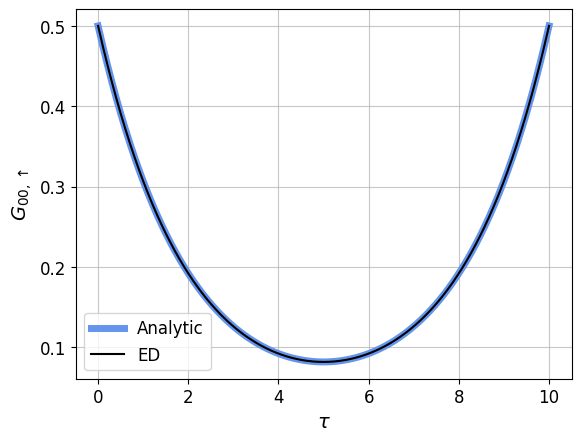

In [ ]:
tau_values, g_samples_over_tau_up, g_samples_over_tau_down = green_tau_analytic(N_sites=1, state_arr=basis_states(N=1), U=1, t_val=0, Lx=1,Ly=1, beta=10, site_j=0,site_n=0)

# Plot the exact diagonalization (ED) result using a blue line
plt.plot(t_exact,  G_analytic, color='cornflowerblue', linewidth=5, label='Analytic')

# Plot the analytic Green's function for spin up using a red line
plt.plot(tau_values, g_samples_over_tau_up, color="black", label="ED")

# Label the x-axis using the imaginary time symbol τ
plt.xlabel(r'$\tau$', fontsize=14)

# Label the y-axis with the Green's function component G_{00,↑}
plt.ylabel(r'$G_{00,\uparrow}$', fontsize=14)

# Set the size of the x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid with dashed lines and reduced opacity for clarity
plt.grid(True, alpha=0.7)

# Show the legend to distinguish the plotted curves
_= plt.legend(fontsize=12)

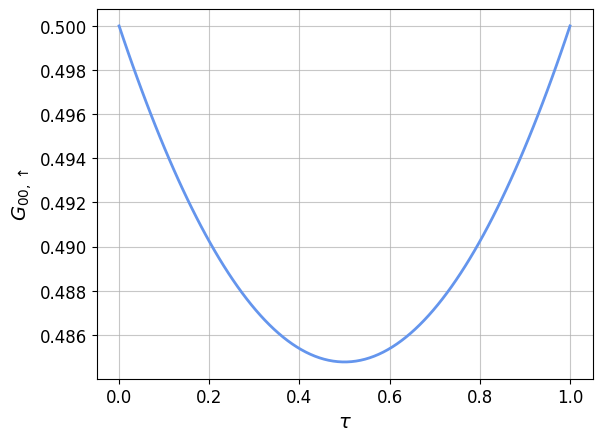

In [ ]:
# Create an array for t values used in the analytic solution and compute  G_analytic
t_exact = np.linspace(0, 1, 100)
G_analytic =  Green_analytic(t_exact, U, 1)

# Plot the exact diagonalization (ED) result using a blue line
plt.plot(t_exact, G_analytic, color='cornflowerblue', linewidth=2, label='Analytic')

# Label the x-axis using the imaginary time symbol τ
plt.xlabel(r'$\tau$', fontsize=14)

# Label the y-axis with the Green's function component G_{00,↑}
plt.ylabel(r'$G_{00,\uparrow}$', fontsize=14)

# Add a grid with dashed lines and reduced opacity for clarity
plt.grid(True,  alpha=0.7)

# Set the size of the x and y ticks
plt.xticks(fontsize=12)
_= plt.yticks(fontsize=12)

In [13]:
# Maximum U and temperature values, and number of steps to sample
U_max = 12
T_max = 6
steps = 100

# Generate an array of U values from 0 to U_max and T values from 0.01 to T_max
U_arr = np.linspace(0, U_max, steps)
T_arr = np.linspace(0.01, T_max, steps)

# Compute the thermal average of the local moment as a function of the on-site interaction U
local_moments_u = [local_moment_therm_avg(1/2, 1, u, 0,1,1) for u in U_arr]

# Compute the thermal average of the local moment as a function of temperature T
local_moments_T = [local_moment_therm_avg(1/temp, 1, 4, 0,1,1) for temp in T_arr]

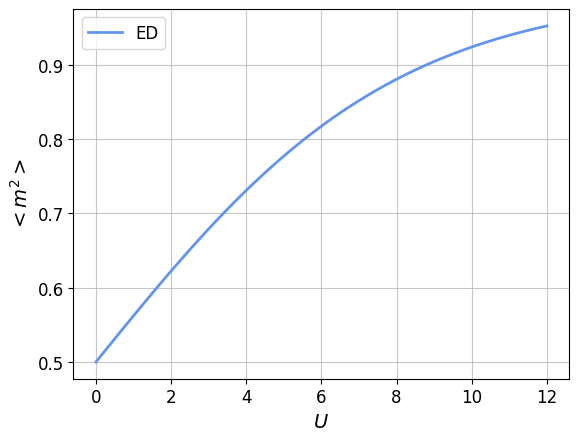

In [ ]:
# Local moment depending on U

# Plot the exact diagonalization (ED) result using a blue line
plt.plot(U_arr, local_moments_u, color='cornflowerblue', linewidth=2, label='ED')

# Label the x-axis using the imaginary time symbol τ
plt.xlabel(r'$U$', fontsize=14)

# Label the y-axis with the Green's function component G_{00,↑}
plt.ylabel(r'$<m^2>$', fontsize=14)

# Add a grid with dashed lines and reduced opacity for clarity
plt.grid(True,   alpha=0.7)

# Set the size of the x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the legend to distinguish the plotted curves
_= plt.legend(fontsize=12)

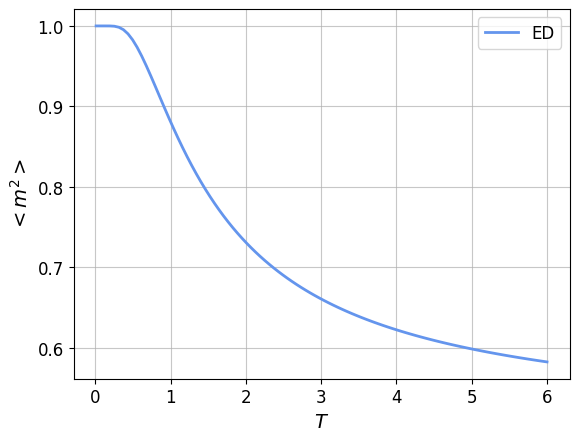

In [ ]:
# Local moment depending on T

# Plot the exact diagonalization (ED) result using a blue line
plt.plot(T_arr, local_moments_T, color='cornflowerblue', linewidth=2, label='ED')

# Label the x-axis using the imaginary time symbol τ
plt.xlabel(r'$T$', fontsize=14)

# Label the y-axis with the Green's function component G_{00,↑}
plt.ylabel(r'$<m^2>$', fontsize=14)

# Add a grid with dashed lines and reduced opacity for clarity
plt.grid(True,   alpha=0.7)

# Set the size of the x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the legend to distinguish the plotted curves
_= plt.legend(fontsize=12)

# Displaying the Greensfunction for the one site, two site and four site case (2D)

In [16]:
# Generate G_samples for four sites (2D), otherwise, for faster representation, the file "green_beta1_U1_multi_sites_ED.csv" can be executed as df and plotted
tau_2d, g_samples_over_tau_up_2d, g_samples_over_tau_down_2d = green_tau_analytic(N_sites = 4, state_arr = basis_states(N=4), U=1, t_val=-1, Lx=2, Ly=2, beta=1, site_j=0, site_n=0)
tau_two_sites, g_samples_over_tau_up_two_sites, g_samples_over_tau_down_two_sites = green_tau_analytic(N_sites = 2, state_arr = basis_states(N=2), U=1, t_val=-1, Lx=2, Ly=1, beta=1, site_j=0, site_n=0)
tau_one_site, g_samples_over_tau_up_one_site, g_samples_over_tau_down_one_site = green_tau_analytic(N_sites = 1, state_arr = basis_states(N=1), U=1, t_val=0, Lx=1, Ly=1, beta=1, site_j=0, site_n=0)

Relative reconstruction error: 1.18e-15
For the execution of 4 sites, it is expected to take 5-6 minutes (tested on Macbook Pro (M2))
Relative reconstruction error: 1.87e-15
Relative reconstruction error: 0.00e+00


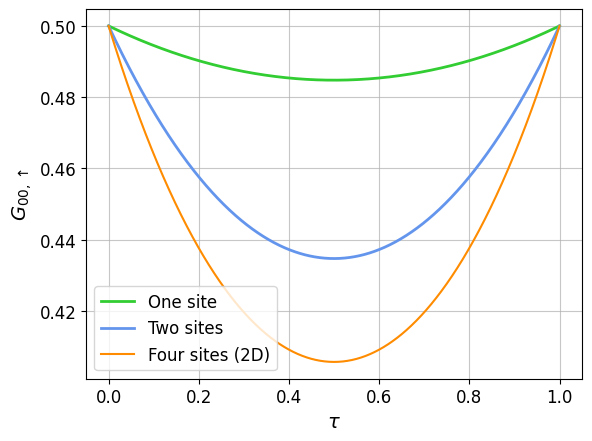

In [ ]:
# Plot the ED Green's function for spin up and different sites. Tau values are the same for each site
plt.plot(tau_one_site, g_samples_over_tau_up_one_site, color="limegreen",linewidth=2,  label="One site")
plt.plot(tau_one_site, g_samples_over_tau_up_two_sites, color="cornflowerblue",linewidth=2, label="Two sites")
plt.plot(tau_one_site, g_samples_over_tau_up_2d, color="darkorange", label="Four sites (2D)")

# Label the x-axis using the imaginary time symbol τ
plt.xlabel(r'$\tau$', fontsize=14)

# Label the y-axis with the Green's function component G_{00,↑}
plt.ylabel(r'$G_{00,\uparrow}$', fontsize=14)

# Add a grid with dashed lines and reduced opacity for clarity
plt.grid(True,   alpha=0.7)

# Set the size of the x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the legend to distinguish the plotted curves
_= plt.legend(loc="lower left", fontsize=12)